# 1. Đọc dữ liệu file user-video và course_video

In [1]:
import pandas as pd
import json
import os
import ast
# Đường dẫn tới các file JSON
file_paths = {
    "user_video": r"D:\Data_labeling\user-video.json",

    
}

# Hàm đọc file JSON và xử lý lỗi
def load_json_to_dataframe(file_path):
    rows = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:  # Đọc từng dòng trong file
            try:
                rows.append(json.loads(line))  # Chuyển dòng thành đối tượng JSON
            except json.JSONDecodeError as e:
                print(f"Lỗi đọc JSON tại file {file_path}, dòng: {line.strip()}, lỗi: {e}")
    return pd.DataFrame(rows) if rows else pd.DataFrame()  # Trả về DataFrame
# Tạo DataFrame cho từng file
user_video = load_json_to_dataframe(file_paths["user_video"])
print(user_video)
# Đọc file csv
course_video = pd.read_csv(r"D:\Data_labeling\course_video.csv")
print(course_video)


                                                      seq     user_id
0       [{'video_id': 'V_1395633', 'segment': [{'start...       U_112
1       [{'video_id': 'V_6224262', 'segment': [{'start...       U_150
2       [{'video_id': 'V_6432959', 'segment': [{'start...       U_172
3       [{'video_id': 'V_6334508', 'segment': [{'start...       U_189
4       [{'video_id': 'V_1358540', 'segment': [{'start...       U_197
...                                                   ...         ...
310355  [{'video_id': 'V_8156324', 'segment': [{'start...  U_36053916
310356  [{'video_id': 'V_6268956', 'segment': [{'start...  U_36053934
310357  [{'video_id': 'V_6388141', 'segment': [{'start...  U_36053946
310358  [{'video_id': 'V_8244595', 'segment': [{'start...  U_36053952
310359  [{'video_id': 'V_6106087', 'segment': [{'start...  U_36053959

[310360 rows x 2 columns]
       Unnamed: 0 course_id resource_id
0               0  C_674903     V_35117
1               1  C_674903     V_35118
2            

# 2. Tiền xử lý dữ liệu

In [5]:



# === Làm sạch bảng user_video ===
# Loại bỏ giá trị thiếu
user_video.dropna(subset=["seq", "user_id"], inplace=True)

# Chuyển đổi các cột không băm được sang định dạng chuỗi
user_video["seq"] = user_video["seq"].astype(str)


# Hàm làm sạch dữ liệu JSON trong cột 'seq'
def clean_seq_data(seq):
    try:
        # Chuyển chuỗi JSON thành danh sách Python
        if isinstance(seq, str):
            return ast.literal_eval(seq)
        return seq  # Nếu đã là danh sách thì giữ nguyên
    except Exception as e:
        print(f"Lỗi khi xử lý chuỗi JSON: {e}")
        return []

# Làm sạch cột 'seq'
user_video["seq"] = user_video["seq"].apply(clean_seq_data)

# Hàm xử lý để tính tổng thời gian học và tần suất từ bảng user_video
def calculate_video_stats(user_video_df):
    # Danh sách lưu trữ thông tin thống kê
    stats = []

    # Duyệt qua từng người dùng
    for _, row in user_video_df.iterrows():
        user_id = row['user_id']
        for record in row['seq']:
            video_id = record['video_id']
            total_study_time = 0
            frequency = 0
            
            # Tính thời gian học và số lần
            for segment in record['segment']:
                start = segment['start_point']
                end = segment['end_point']
                total_study_time += end - start  # Tính thời gian học
                frequency += 1  # Đếm tần suất
            
            # Lưu kết quả
            stats.append({
                "user_id": user_id,
                "video_id": video_id,
                "total_study_time": total_study_time,
                "frequency": frequency
            })
    
    # Trả về DataFrame thống kê
    return pd.DataFrame(stats)

# Tính toán thông tin tần suất và thời gian học
stats_df = calculate_video_stats(user_video)
print(stats_df)



             user_id   video_id  total_study_time  frequency
0              U_112  V_1395633            157.45          4
1              U_112  V_1395635             35.00          1
2              U_112  V_1395636             52.50          1
3              U_112  V_1395639             12.50          2
4              U_112  V_6210799            319.25          4
...              ...        ...               ...        ...
21295742  U_36053916  V_8156324              9.50          1
21295743  U_36053934  V_6268956            155.00          1
21295744  U_36053946  V_6388141             10.00          1
21295745  U_36053952  V_8244595             45.00          6
21295746  U_36053959  V_6106087             55.00          2

[21295747 rows x 4 columns]


In [6]:
# Lọc các hàng có giá trị âm trong cột 'total_study_time'
negative_study_time = stats_df[stats_df['total_study_time'] < 0]

# Kiểm tra kết quả
print(negative_study_time)


             user_id   video_id  total_study_time  frequency
34             U_197  V_1358568           -468.75          4
76             U_197  V_1358765           -433.60          1
82             U_197  V_1358782           -352.10          2
189            U_783  V_1358675            -99.00         10
228           U_1071  V_1358581            -95.30          5
...              ...        ...               ...        ...
21295383  U_36051429  V_6267465           -346.30          2
21295523  U_36052067  V_6375502            -19.70          1
21295581  U_36052491  V_6234827          -5767.30         19
21295582  U_36052491  V_6234830           -213.20          4
21295691  U_36053306  V_6325346           -384.70          2

[18403 rows x 4 columns]


In [7]:
# Xóa các hàng có giá trị âm trong cột 'total_study_time'
stats_df = stats_df[stats_df['total_study_time'] >= 0]
# Merge 2 bảng user_video và course_video 
course_video.rename(columns={'resource_id': 'video_id'}, inplace=True)
merged_df = pd.merge(course_video, stats_df, on='video_id', how='inner')

In [11]:
print(merged_df)

        Unnamed: 0 course_id   video_id     user_id  total_study_time  \
0              196  C_674920  V_1641825     U_97963             265.1   
1              196  C_674920  V_1641825   U_5146831             289.9   
2              196  C_674920  V_1641825   U_9013964             315.0   
3              196  C_674920  V_1641825  U_13503162             320.0   
4              196  C_674920  V_1641825  U_14791778              74.5   
...            ...       ...        ...         ...               ...   
116759       65658  C_697828   V_559945  U_11959429             241.4   
116760       65659  C_697828   V_559946  U_11959429              79.8   
116761       65660  C_697828   V_559947  U_11959429             227.3   
116762       65661  C_697828   V_559948  U_11959429             370.7   
116763       65662  C_697828   V_559949  U_11959429             160.3   

        frequency  
0               1  
1               2  
2               2  
3               2  
4               9  
...

# 3. Gán nhãn cho tiêu chí tần suất và thời học video

In [15]:




# Gán nhãn dựa trên tổng thời gian học và tần suất
def assign_labels(row):
    # Gán nhãn thời gian học
    if row['total_study_time'] < 30:
        time_label = "Low"
    elif 30 <= row['total_study_time'] < 60:
        time_label = "Medium"
    else:
        time_label = "High"

    # Gán nhãn tần suất
    if row['frequency'] < 2:
        freq_label = "Low"
    elif 2 <= row['frequency'] < 5:
        freq_label = "Medium"
    else:
        freq_label = "High"
    
    return time_label, freq_label

# Áp dụng hàm gán nhãn
merged_df[['time_label', 'freq_label']] = merged_df.apply(assign_labels, axis=1, result_type="expand")
merged_df = merged_df.drop('Unnamed: 0', axis=1)

# Xuất kết quả
print(merged_df)


       course_id   video_id     user_id  total_study_time  frequency  \
0       C_674920  V_1641825     U_97963             265.1          1   
1       C_674920  V_1641825   U_5146831             289.9          2   
2       C_674920  V_1641825   U_9013964             315.0          2   
3       C_674920  V_1641825  U_13503162             320.0          2   
4       C_674920  V_1641825  U_14791778              74.5          9   
...          ...        ...         ...               ...        ...   
116759  C_697828   V_559945  U_11959429             241.4          1   
116760  C_697828   V_559946  U_11959429              79.8          1   
116761  C_697828   V_559947  U_11959429             227.3          2   
116762  C_697828   V_559948  U_11959429             370.7          2   
116763  C_697828   V_559949  U_11959429             160.3          2   

       time_label freq_label  
0            High        Low  
1            High     Medium  
2            High     Medium  
3          

# 4. Gán nhãn tổng hợp

In [17]:
from sklearn.preprocessing import LabelEncoder

In [21]:
# Chuyển đổi các thuộc tính phân loại 'time_label' và 'freq_label' thành các giá trị số
label_encoder = LabelEncoder()

# Giả sử time_label và freq_label có các giá trị như sau: Low = 1, Medium = 2, High = 0
merged_df['time_label_encoded'] = label_encoder.fit_transform(merged_df['time_label'])
merged_df['freq_label_encoded'] = label_encoder.fit_transform(merged_df['freq_label'])

# Hàm gán nhãn mới theo quy tắc đã cho
def assign_new_label(row):
    if row['time_label_encoded'] == 1 and row['freq_label_encoded'] == 1:
        return 1  # Cả hai đều Low -> nhãn 1
    elif (row['time_label_encoded'] == 1 and row['freq_label_encoded'] == 2) or \
         (row['time_label_encoded'] == 2 and row['freq_label_encoded'] == 1):
        return 2  # Một trong hai là Low và một là Medium -> nhãn 2
    elif (row['time_label_encoded'] == 1 and row['freq_label_encoded'] == 0) or \
         (row['time_label_encoded'] == 0 and row['freq_label_encoded'] == 1):
        return 3  # Một trong hai là Low và một là High -> nhãn 3
    elif row['time_label_encoded'] == 2 and row['freq_label_encoded'] == 2:
        return 4  # Cả hai đều Medium -> nhãn 4
    else:
        return 5  # Cả hai đều High/High-Medium hoặc Medium-High -> nhãn 5

# Áp dụng logic gán nhãn mới
merged_df['new_label'] = merged_df.apply(assign_new_label, axis=1)
print(merged_df)

       course_id   video_id     user_id  total_study_time  frequency  \
0       C_674920  V_1641825     U_97963             265.1          1   
1       C_674920  V_1641825   U_5146831             289.9          2   
2       C_674920  V_1641825   U_9013964             315.0          2   
3       C_674920  V_1641825  U_13503162             320.0          2   
4       C_674920  V_1641825  U_14791778              74.5          9   
...          ...        ...         ...               ...        ...   
116759  C_697828   V_559945  U_11959429             241.4          1   
116760  C_697828   V_559946  U_11959429              79.8          1   
116761  C_697828   V_559947  U_11959429             227.3          2   
116762  C_697828   V_559948  U_11959429             370.7          2   
116763  C_697828   V_559949  U_11959429             160.3          2   

       time_label freq_label  time_label_encoded  freq_label_encoded  \
0            High        Low                   0               

In [23]:
# Lọc chỉ hai cột course_id và new_label
merged_df = merged_df[['course_id', 'new_label']]

In [25]:
print(merged_df)

       course_id  new_label
0       C_674920          3
1       C_674920          5
2       C_674920          5
3       C_674920          5
4       C_674920          5
...          ...        ...
116759  C_697828          3
116760  C_697828          3
116761  C_697828          5
116762  C_697828          5
116763  C_697828          5

[116764 rows x 2 columns]


In [38]:
# Nhóm theo course_id và tính trung bình nhãn mới cho từng khóa học
course_avg_labels = merged_df.groupby('course_id')['new_label'].mean().reset_index()

# Làm tròn giá trị trung bình nhãn về 1, 2, 3, 4, 5
course_avg_labels['new_label'] = course_avg_labels['new_label'].round()

# Đảm bảo nhãn nằm trong khoảng từ 1 đến 5
course_avg_labels['new_label'] = course_avg_labels['new_label'].clip(1, 5)
print(course_avg_labels)

     course_id  new_label
0    C_1159827        4.0
1    C_1410156        3.0
2    C_1428968        3.0
3    C_1429002        2.0
4    C_1434593        4.0
..         ...        ...
298   C_948433        5.0
299   C_948435        3.0
300   C_948468        4.0
301   C_948486        4.0
302   C_949540        5.0

[303 rows x 2 columns]


# 5. Xuất biểu đồ đã được gán nhãn theo tiêu chí 2

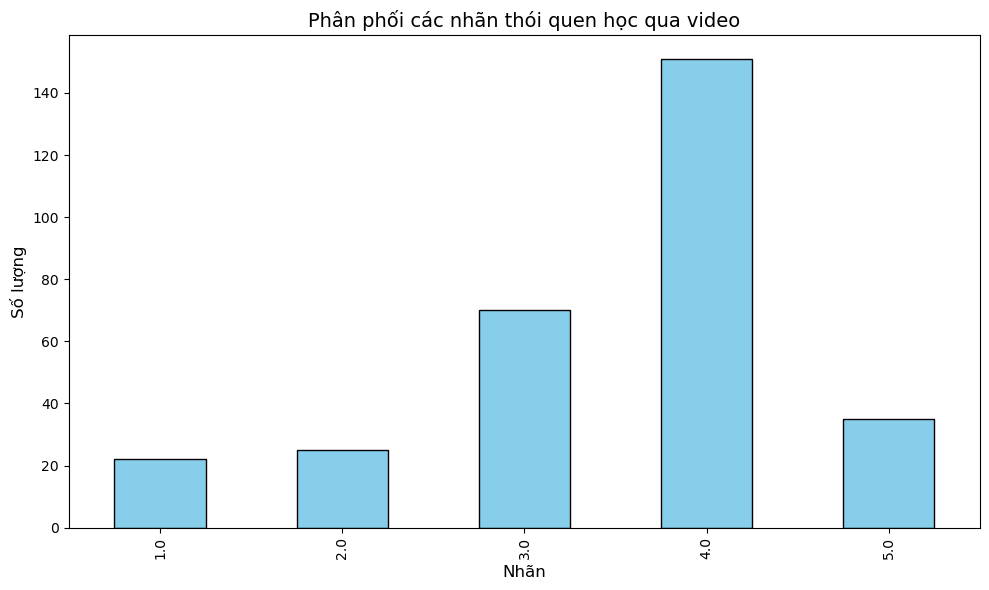

In [36]:
import matplotlib.pyplot as plt
# Hiển thị biểu đồ phân bố các nhãn
plt.figure(figsize=(10, 6))
course_avg_labels['new_label'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Phân phối các nhãn thói quen học qua video', fontsize=14)
plt.xlabel('Nhãn', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.tight_layout()
plt.show()